In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  '/content/drive/MyDrive/Phenikaa University/PU-Y4-S3/Advanced reinforcement learning/Midterm/Flappy_Bird_DQN'

/content/drive/.shortcut-targets-by-id/13j2XuyYPHqTkaDdmtS4n5KBvubsZtIQa/Phenikaa University/PU-Y4-S3/Advanced reinforcement learning/Midterm/Flappy_Bird_DQN


In [ ]:
!ls

 assets   checkpoints  'Deep Q Learning.ipynb'	 DQN.py   game	 log   play_game.py


## Importing necessary libraries:

In [ ]:
import os
import pygame
DISPLAY = True
if not DISPLAY:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
import os, sys
sys.path.append('game/')
import flappy_wrapped as game
import cv2
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

## Khai bao siêu tham số


## Defining function used to preprocess game frame data (converting to grayscale):

In [ ]:
KERNEL = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])
IMAGE_SIZE = 84
def processFrame(image):
    # env.SCREENWIDTH = 288
    # env.BASEY = 404
    frame = image[55:288, :404] # crop image ->
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # convert image to black and white
    frame = cv2.resize(frame,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
    _ , frame = cv2.threshold(frame,50,255,cv2.THRESH_BINARY)
    frame = cv2.filter2D(frame,-1,KERNEL)
    frame = frame.astype(np.float64)/255.0
    return frame

In [ ]:
ACTIONS = [0,1] # action of Agent
EXPERIENCE_BUFFER_SIZE = 2000   # Size of memory experience
STATE_DIM = 4   # the number of state's dimentions
GAMMA = 0.99
EPSILON_START = 1
EPSILON_FINAL = 0.001
EPSILON_DECAY_FRAMES = (10**4)/3
MEAN_GOAL_REWARD = 10   # The number of goal
BATCH_SIZE = 32
MIN_EXP_BUFFER_SIZE = 500
SYNC_TARGET_FRAMES = 30
LEARNING_RATE = 1e-4
SKIP_FRAME = 2
INITIAL_SKIP = [0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1]

EPOCHS_MAX = 2000

## Creat Agent, ExperienceBuffer, Loss

In [ ]:
class Agent():
    def __init__(self,env,buffer,t_model="DQN",state_buffer_size = STATE_DIM):
        self.env = env
        self.exp_buffer = buffer
        self.t_model = t_model
        self.state_buffer_size = state_buffer_size
        self.state = collections.deque(maxlen = self.state_buffer_size)
        self.next_state= collections.deque(maxlen = self.state_buffer_size)
        self._reset()

    def _reset(self):
        self.total_rewards = 0
        self.state.clear()
        self.next_state.clear()

        for i in INITIAL_SKIP[:-7]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-7:-5]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-5:-3]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-3:-1]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)

    def step(self,net,tgt_net,epsilon=0.9,device='cpu'):
        self.total_rewards = 0
        if np.random.random() < epsilon:
            action = np.random.choice(ACTIONS)
        else:
            state_v = torch.tensor(np.array([self.state],copy=False),dtype=torch.float32).to(device)
            action = int(torch.argmax(net(state_v)))

        image,reward,done = self.env.frame_step(action)
        self.total_rewards += reward
        for _ in range(SKIP_FRAME):
                image,reward,done =  self.env.frame_step(action)
                self.total_rewards += reward
                if done:
                    break

        frame = processFrame(image)
        self.next_state.append(frame)

        if len(self.next_state)==self.state_buffer_size and len(self.state)==self.state_buffer_size:
            if self.t_model == "DQN":
                self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()))
            else:
                #PER - Prioritized Experience Replay
                o = net( torch.tensor( np.array([self.state]),dtype=torch.float32).to(device)).to('cpu').detach().numpy()[0][action]
                e = float(torch.max(tgt_net( torch.tensor( np.array([self.next_state]),dtype=torch.float32).to(device))))
                p = abs(o-e)+0.0001
                self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()),p)

        self.state.append(frame)

        end_reward = int(self.total_rewards)
        if done:
            self._reset()

        return end_reward

In [ ]:
class ExperienceBuffer():
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def clear(self):
        self.buffer.clear()

    def __len__(self):
        return len(self.buffer)

    def append(self,exp):
        self.buffer.append(exp)

    def sample(self,batch_size):
        indices = np.random.choice( range(len(self.buffer)), batch_size)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

In [ ]:
class ExperienceBufferPER():
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.priority = collections.deque(maxlen=capacity)

    def clear(self):
        self.buffer.clear()
        self.priority.clear()

    def __len__(self):
        return len(self.buffer)

    def append(self,exp,p):
        self.buffer.append(exp)
        self.priority.append(p)

    def sample(self,batch_size):
        probs = np.array(self.priority)/sum(np.array(self.priority))
        indices = np.random.choice( range(len(self.buffer)), batch_size, p = probs)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

In [ ]:
def calc_loss_DQN(batch,net,device='cpu'):
    states,actions,rewards,dones,next_states = batch

    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_state_action_values = net(next_states_v)
    next_state_action_values = rewards_v + GAMMA * ((1-dones_v)*torch.max(next_state_action_values,dim=1)[0])

    next_state_action_values = next_state_action_values.detach()

    expected_values = rewards_v +  next_state_action_values * GAMMA
    return nn.MSELoss()(state_action_values,expected_values)

In [ ]:
def calc_loss_DDQN(batch,net,tgt_net,device='cpu'):
    states,actions,rewards,dones,next_states = batch

    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_action_values = tgt_net(next_states_v).max(1)[0]
    # next_state_action_values[dones_v] = 0.0
    next_state_action_values = next_state_action_values.detach()

    expected_values = rewards_v +  next_state_action_values * GAMMA
    return nn.MSELoss()(state_action_values,expected_values)

## DQN Models

### Deep Q-Network

In [ ]:
#@title Model DQN
class DQN(nn.Module):
    def __init__(self, input_shape=[4,84,84], nactions=2):
        super(DQN, self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, nactions)
        )

    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        x = self.fc(conv_out)

        return x

### Dueling DQN

In [ ]:
#@title Model Dueling DQN
class DDQN(nn.Module):
    def __init__(self,input_shape,nactions):
        super(DDQN,self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fca = nn.Sequential(
            nn.Linear( conv_out_size, 512),
            nn.ReLU(),
            nn.Linear( 512, nactions )
        )

        self.fcv = nn.Sequential(
            nn.Linear(conv_out_size,512),
            nn.ReLU(),
            nn.Linear(512,1)
        )

    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))

    def forward(self,x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        action_v = self.fca(conv_out)
        value_v = self.fcv(conv_out).expand(x.size(0), self.nactions)
        return value_v + action_v - action_v.mean(1).unsqueeze(1).expand(x.size(0), self.nactions)

## Training

### DQN with experience replay

In [ ]:
all_losses = []
all_epsilons = []
all_rewards = []

net = DQN((STATE_DIM,IMAGE_SIZE,IMAGE_SIZE), len(ACTIONS)).to(device)

env = game.GameState()
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE)
agent = Agent(env,buffer,t_model="DQN")
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )

    reward = agent.step(net,0,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%10 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward

            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DQN.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break

    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DQN(batch,net,device=device)
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()


# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/DQN.csv')


REWARD -inf -> -1.0. Model Saved
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -1.0
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -1.0
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -1.0
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -0.95
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.96
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.9666666666666667
GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.9714285714285714
GAME : 80 | EPSILON : 0.9763 | MEAN REWARD : -0.975
GAME : 90 | EPSILON : 0.9733 | MEAN REWARD : -0.9555555555555556
GAME : 100 | EPSILON : 0.9703 | MEAN REWARD : -0.96
GAME : 110 | EPSILON : 0.9673 | MEAN REWARD : -0.96
GAME : 120 | EPSILON : 0.9643 | MEAN REWARD : -0.94
GAME : 130 | EPSILON : 0.9613 | MEAN REWARD : -0.92
GAME : 140 | EPSILON : 0.9583 | MEAN REWARD : -0.94
GAME : 150 | EPSILON : 0.9553 | MEAN REWARD : -0.9
GAME : 160 | EPSILON : 0.9523 | MEAN REWARD : -0.9
GAME : 170 | EPSILON : 0.9493 | MEAN REWARD : -0.9
GAME : 180 | EPSILON : 0.9463 | MEAN REWARD : -0.9
GAME

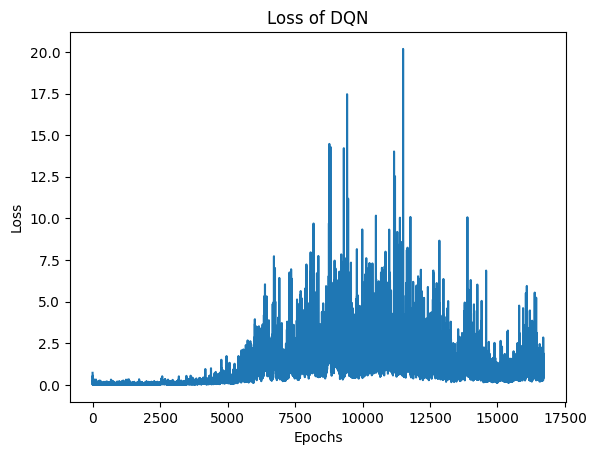

In [ ]:
plt.title("Loss of DQN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_DQN.png')

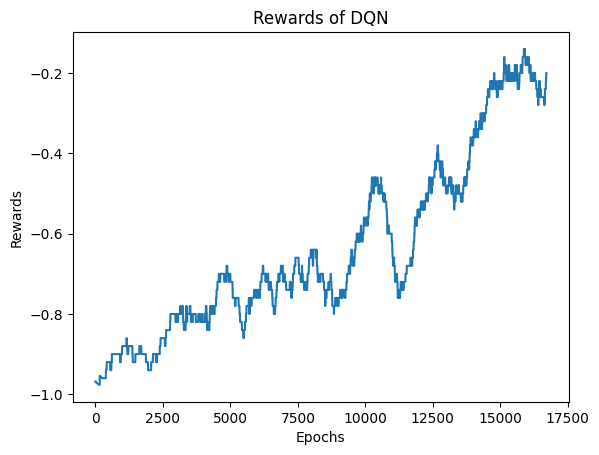

In [ ]:
plt.title("Rewards of DQN")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_DQN.png')


### Double DQN


In [ ]:
#@title Double DQN

all_losses = []
all_epsilons = []
all_rewards = []


net = DQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)

env = game.GameState()
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE)
agent = Agent(env,buffer)
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )

    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward

            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DDQN.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break

    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DDQN(batch,net,tgt_net,device=device)
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()

# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/DDQN.csv')

REWARD -inf -> -1.0. Model Saved
GAME : 5 | EPSILON : 0.9988 | MEAN REWARD : -1.0
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -1.0
GAME : 15 | EPSILON : 0.9958 | MEAN REWARD : -1.0
REWARD -1.0 -> -0.875. Model Saved
REWARD -0.875 -> -0.7647058823529411. Model Saved
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -0.8
GAME : 25 | EPSILON : 0.9928 | MEAN REWARD : -0.76
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -0.7333333333333333
GAME : 35 | EPSILON : 0.9898 | MEAN REWARD : -0.7142857142857143
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -0.7
GAME : 45 | EPSILON : 0.9868 | MEAN REWARD : -0.7333333333333333
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.76
GAME : 55 | EPSILON : 0.9838 | MEAN REWARD : -0.7454545454545455
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.7333333333333333
GAME : 65 | EPSILON : 0.9808 | MEAN REWARD : -0.7538461538461538
GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.7714285714285715
GAME : 75 | EPSILON : 0.9778 | MEAN REWARD : -0.7866666666666666
GAME : 80 |

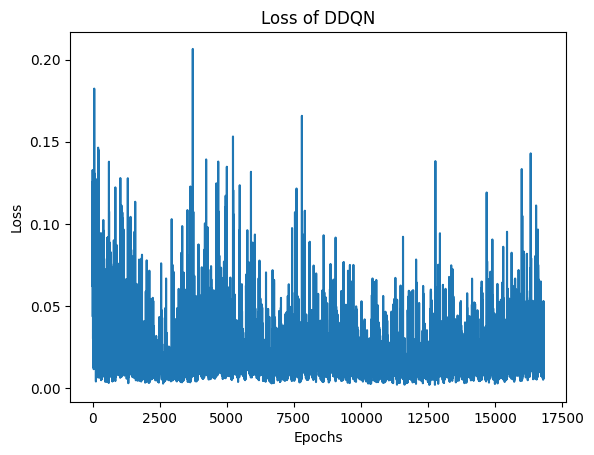

In [ ]:
plt.title("Loss of DDQN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_DDQN.png')

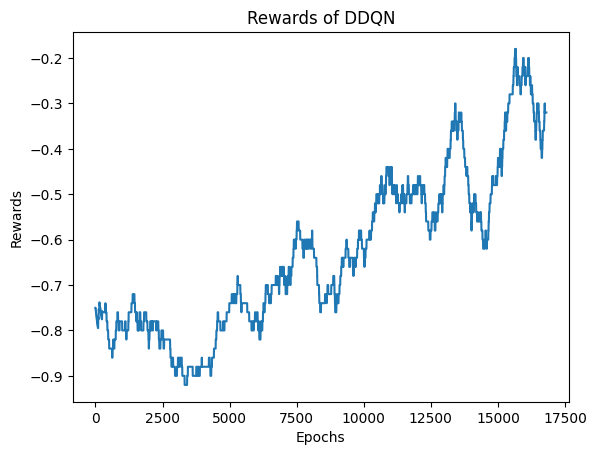

In [ ]:
plt.title("Rewards of DDQN")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_DDQN.png')

In [ ]:
#@title Dueling DDQN with

all_losses = []
all_epsilons = []
all_rewards = []


net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)

env = game.GameState()
buffer = ExperienceBufferPER(EXPERIENCE_BUFFER_SIZE)
agent = Agent(env,buffer, t_model="PER")
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )

    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward

            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DuelingDQN_PER.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break

    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DDQN(batch,net,tgt_net,device=device)
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()

# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/Dueling_DDQN.csv')

REWARD -inf -> -1.0. Model Saved
GAME : 5 | EPSILON : 0.9988 | MEAN REWARD : -1.0
REWARD -1.0 -> -0.6666666666666666. Model Saved
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -0.8
GAME : 15 | EPSILON : 0.9958 | MEAN REWARD : -0.8666666666666667
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -0.9
GAME : 25 | EPSILON : 0.9928 | MEAN REWARD : -0.92
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -0.9333333333333333
GAME : 35 | EPSILON : 0.9898 | MEAN REWARD : -0.9428571428571428
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -0.95
GAME : 45 | EPSILON : 0.9868 | MEAN REWARD : -0.9555555555555556
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.96
GAME : 55 | EPSILON : 0.9838 | MEAN REWARD : -0.9272727272727272
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.9
GAME : 65 | EPSILON : 0.9808 | MEAN REWARD : -0.9076923076923077
GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.9142857142857143
GAME : 75 | EPSILON : 0.9778 | MEAN REWARD : -0.92
GAME : 80 | EPSILON : 0.9763 | MEAN REWARD : -0.925
GAME : 85

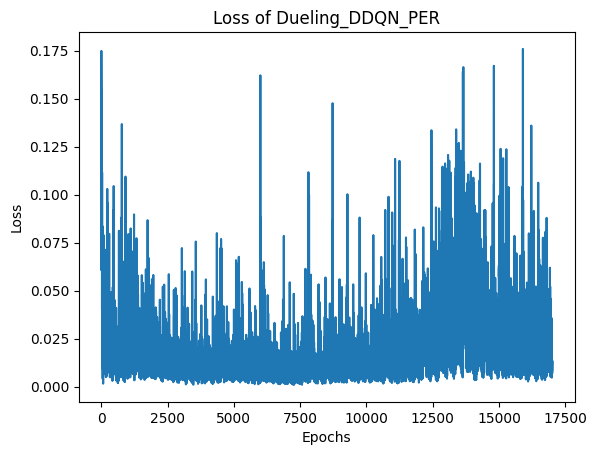

In [ ]:
plt.title("Loss of Dueling_DDQN_PER")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_Dueling_DDQN_PER.png')

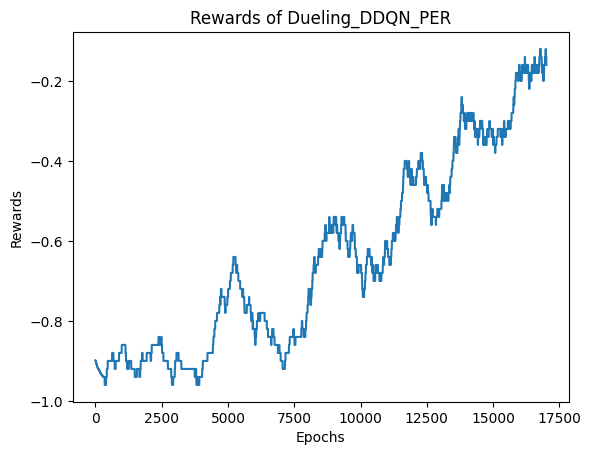

In [ ]:
plt.title("Rewards of Dueling_DDQN_PER")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_Dueling_DDQN_PER.png')

Continues training

In [ ]:
#@title Dueling DDQN with

all_losses = []
all_epsilons = []
all_rewards = []


net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)

net.load_state_dict(torch.load('checkpoints/best_DuelingDQN_PER.dat'))
tgt_net.load_state_dict(torch.load('checkpoints/best_DuelingDQN_PER.dat'))
env = game.GameState()
buffer = ExperienceBufferPER(EXPERIENCE_BUFFER_SIZE)
agent = Agent(env,buffer, t_model="PER")
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )

    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward

            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DuelingDQN_PER.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break

    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DDQN(batch,net,tgt_net,device=device)
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()

# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/Dueling_DDQN2.csv')